# Predict CLTV of a customer

In [1]:
# importing imp libraries
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [2]:
from scipy.stats import normaltest,f_oneway
from scipy.stats import ttest_ind

In [3]:
import statsmodels.api as sm

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [6]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
from sklearn.feature_selection import RFE

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

In [9]:
!pip install mlxtend

In [10]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Data Reading and Understanding

In [11]:
df = pd.read_csv("train_BRCpofr.csv")
df.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736


In [12]:
# checking shape
df.shape

(89392, 12)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89392 entries, 0 to 89391
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              89392 non-null  int64 
 1   gender          89392 non-null  object
 2   area            89392 non-null  object
 3   qualification   89392 non-null  object
 4   income          89392 non-null  object
 5   marital_status  89392 non-null  int64 
 6   vintage         89392 non-null  int64 
 7   claim_amount    89392 non-null  int64 
 8   num_policies    89392 non-null  object
 9   policy          89392 non-null  object
 10  type_of_policy  89392 non-null  object
 11  cltv            89392 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 8.2+ MB


In [14]:
df.describe()

,id,marital_status,vintage,claim_amount,cltv
count,89392.000000,89392.000000,89392.000000,89392.000000,89392.000000
mean,44696.500000,0.575488,4.595669,4351.502416,97952.828978
std,25805.391969,0.494272,2.290446,3262.359775,90613.814793
min,1.000000,0.000000,0.000000,0.000000,24828.000000
25%,22348.750000,0.000000,3.000000,2406.000000,52836.000000
50%,44696.500000,1.000000,5.000000,4089.000000,66396.000000
75%,67044.250000,1.000000,6.000000,6094.000000,103440.000000
max,89392.000000,1.000000,8.000000,31894.000000,724068.000000


In [15]:
# dropping "id" column
df = df.drop('id', axis = 1)
df.head()

,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736


In [16]:
#converting vintage and marital_status column to categorical
df['vintage'] = pd.Categorical(df['vintage'])
df['marital_status'] = pd.Categorical(df['marital_status'])

In [17]:
# Checking for the null values
100*df.isnull().mean()

gender            0.0
area              0.0
qualification     0.0
income            0.0
marital_status    0.0
vintage           0.0
claim_amount      0.0
num_policies      0.0
policy            0.0
type_of_policy    0.0
cltv              0.0
dtype: float64

# Data Visualization

In [18]:
df.columns

Index(['gender', 'area', 'qualification', 'income', 'marital_status',
       'vintage', 'claim_amount', 'num_policies', 'policy', 'type_of_policy',
       'cltv'],
      dtype='object')

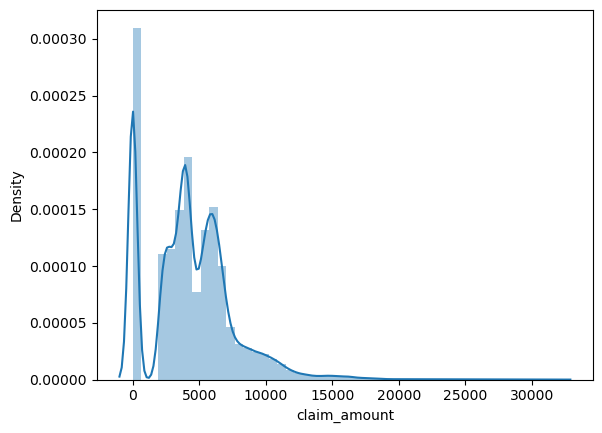

In [19]:
sns.distplot(df['claim_amount'])
plt.show()

In [20]:
df['claim_amount'].skew()

1.0442327522818384

In [21]:
df.dtypes

gender              object
area                object
qualification       object
income              object
marital_status    category
vintage           category
claim_amount         int64
num_policies        object
policy              object
type_of_policy      object
cltv                 int64
dtype: object

In [22]:
df1 = df.copy()

# Data Preparation

In [23]:
# converting dummy variable for all categorical columns and dropping first column
df1 = pd.get_dummies(df1, drop_first = True)
df1.shape

(89392, 23)

In [24]:
df1.head()

,claim_amount,cltv,gender_Male,area_Urban,qualification_High School,qualification_Others,income_5L-10L,income_<=2L,income_More than 10L,marital_status_1,...,vintage_4,vintage_5,vintage_6,vintage_7,vintage_8,num_policies_More than 1,policy_B,policy_C,type_of_policy_Platinum,type_of_policy_Silver
0,5790,64308,1,1,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,5080,515400,1,0,1,0,1,0,0,0,...,0,0,0,0,1,1,0,0,1,0
2,2599,64212,1,1,0,0,1,0,0,1,...,0,0,0,0,1,1,0,0,1,0
3,0,97920,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0
4,3508,59736,1,1,1,0,0,0,1,1,...,0,0,1,0,0,1,0,0,0,0


# Model 1 : Linear Regression

In [25]:
X = df1.drop('cltv',axis=1)
y = df1['cltv']

In [26]:
X_sm = X
X_sm = sm.add_constant(X_sm)
lm = sm.OLS(y,X_sm).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cltv   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     730.0
Date:                Sun, 22 Jan 2023   Prob (F-statistic):               0.00
Time:                        16:03:19   Log-Likelihood:            -1.1398e+06
No. Observations:               89392   AIC:                         2.280e+06
Df Residuals:                   89369   BIC:                         2.280e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      4.486e+04   1781.561     25.179      0.000    4.14e+04    4.83e+04
claim_amount                  2.6895      0.098     27.396      0.000       2.497       2.882
gender_Male                2346.5316    568.202      4.130      0.000    1232.861    3460.202
area_Urban                 6256.4461    702.887      8.901      0.000    4878.795    7634.097
qualification_High School  -934.1080    576.177     -1.621      0.105   -2063.410     195.194
qualification_Others      -8042.4169   1431.899     -5.617      0.000   -1.08e+04   -5235.909
income_5L-10L             -5017.7654    702.874     -7.139      0.000   -6395.393   -3640.138
income_<=2L               -4408.2567   2027.996     -2.174      0.030   -8383.109    -433.405
income_More than 10L      -7051.6140    948.413     -7.435      0.000   -8910.494   -5192.734
marital_status_1          -7212.3085    572.829    -12.591      0.000   -8335.047   -6089.570
vintage_1                  1507.4014   1624.595      0.928      0.353   -1676.790    4691.593
vintage_2                  3299.8706   1579.773      2.089      0.037     203.531    6396.211
vintage_3                  5572.9912   1649.506      3.379      0.001    2339.976    8806.007
vintage_4                  3575.7591   1548.381      2.309      0.021     540.947    6610.571
vintage_5                  2732.0335   1513.343      1.805      0.071    -234.104    5698.171
vintage_6                  3451.9331   1457.821      2.368      0.018     594.617    6309.249
vintage_7                  3436.0662   1506.097      2.281      0.023     484.130    6388.003
vintage_8                  3953.3458   1629.556      2.426      0.015     759.431    7147.260
num_policies_More than 1   6.484e+04    611.741    105.991      0.000    6.36e+04     6.6e+04
policy_B                  -7629.5124    668.095    -11.420      0.000   -8938.973   -6320.052
policy_C                   9648.1913    995.086      9.696      0.000    7697.832    1.16e+04
type_of_policy_Platinum    -671.0221    697.782     -0.962      0.336   -2038.668     696.624
type_of_policy_Silver     -2414.0159    825.293     -2.925      0.003   -4031.583    -796.449
==============================================================================
Omnibus:                    51163.716   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           403287.323
Skew:                           2.731   Prob(JB):                         0.00
Kurtosis:                      11.857   Cond. No.                     7.88e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.88e+04. This might indicate 

In [27]:
X_train1,X_test1,y_train1,y_test1 = train_test_split(X,y,test_size=0.3,random_state=100)

In [28]:
lr.fit(X_train1,y_train1)
y_pred1 = lr.predict(X_test1)
residuals = y_pred1-y_test1
mean_of_residuals = np.mean(residuals)
print(f"The mean of the residuals is {mean_of_residuals}")

The mean of the residuals is -206.36787585063996


The 2nd assumption is that the mean of the residual's must be close to zero, which fail's.

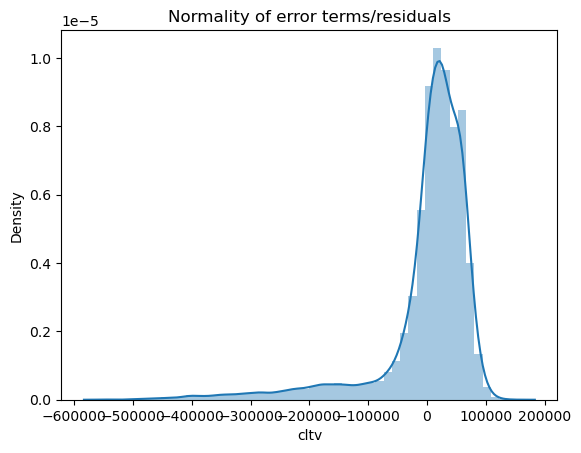

In [29]:
p = sns.distplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

The distribution clearly show's that the residuals are not normally distributed,

# Model 2 : Nonlinear Transformation

In [30]:
df2 = df1.copy()
df2.head()

,claim_amount,cltv,gender_Male,area_Urban,qualification_High School,qualification_Others,income_5L-10L,income_<=2L,income_More than 10L,marital_status_1,...,vintage_4,vintage_5,vintage_6,vintage_7,vintage_8,num_policies_More than 1,policy_B,policy_C,type_of_policy_Platinum,type_of_policy_Silver
0,5790,64308,1,1,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,5080,515400,1,0,1,0,1,0,0,0,...,0,0,0,0,1,1,0,0,1,0
2,2599,64212,1,1,0,0,1,0,0,1,...,0,0,0,0,1,1,0,0,1,0
3,0,97920,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0
4,3508,59736,1,1,1,0,0,0,1,1,...,0,0,1,0,0,1,0,0,0,0


<AxesSubplot:xlabel='claim_amount', ylabel='Density'>

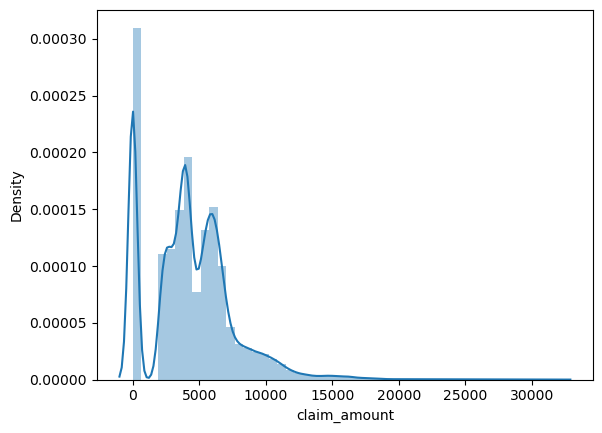

In [31]:
sns.distplot(df2['claim_amount'])

In [32]:
df['claim_amount'].skew()

1.0442327522818384

As column "claim_amount" is skewed, we are applying non linear transformation

In [33]:
from scipy.special import boxcox1p
lam = 0.15
df2['claim_amount'] = boxcox1p(df2['claim_amount'],lam)
df2['claim_amount'].skew()

-1.3529938969229431

In [34]:
df2['cltv'].skew()

2.7530651590601143

Also transforming target variable as log transformation

In [35]:
df2['cltv'] = np.log(df2['cltv'])
df2['cltv'].skew()

0.9091111515047653

In [36]:
df2_train, df2_test = train_test_split(df2, train_size=0.7, random_state=100)

In [37]:
df2_train.head()

,claim_amount,cltv,gender_Male,area_Urban,qualification_High School,qualification_Others,income_5L-10L,income_<=2L,income_More than 10L,marital_status_1,...,vintage_4,vintage_5,vintage_6,vintage_7,vintage_8,num_policies_More than 1,policy_B,policy_C,type_of_policy_Platinum,type_of_policy_Silver
13433,19.610542,11.053933,0,1,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2047,21.408946,12.809043,1,1,1,0,1,0,0,0,...,0,0,0,0,1,1,1,0,0,0
68766,15.349906,10.832023,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,1,0,1
2709,18.382579,12.198383,0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,1,0,1,0
41891,15.234567,11.108440,0,1,0,0,1,0,0,1,...,0,1,0,0,0,1,1,0,0,0


In [38]:
scaler = StandardScaler()

In [39]:
df2_train[['claim_amount']]= scaler.fit_transform(df2_train[['claim_amount']])
df2_test[['claim_amount']]= scaler.transform(df2_test[['claim_amount']])

In [40]:
X_train= df2_train.drop('cltv',axis=1)
y_train = df2_train['cltv']

In [41]:
X_test= df2_test.drop('cltv',axis=1)
y_test = df2_test['cltv']

In [42]:
X_sm_train = X_train
X_sm_train = sm.add_constant(X_sm_train)
lm = sm.OLS(y_train,X_sm_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cltv   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     1302.
Date:                Sun, 22 Jan 2023   Prob (F-statistic):               0.00
Time:                        16:03:20   Log-Likelihood:                -50090.
No. Observations:               62574   AIC:                         1.002e+05
Df Residuals:                   62551   BIC:                         1.004e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        10.7638      0.014    786.601      0.000      10.737      10.791
claim_amount                  0.0408      0.003     16.112      0.000       0.036       0.046
gender_Male                   0.0107      0.004      2.448      0.014       0.002       0.019
area_Urban                    0.0472      0.006      8.484      0.000       0.036       0.058
qualification_High School    -0.0045      0.004     -1.016      0.310      -0.013       0.004
qualification_Others         -0.0749      0.011     -6.768      0.000      -0.097      -0.053
income_5L-10L                -0.0371      0.005     -6.862      0.000      -0.048      -0.027
income_<=2L                  -0.0230      0.016     -1.459      0.144      -0.054       0.008
income_More than 10L         -0.0499      0.007     -6.824      0.000      -0.064      -0.036
marital_status_1             -0.0591      0.004    -13.427      0.000      -0.068      -0.051
vintage_1                     0.0077      0.012      0.620      0.535      -0.017       0.032
vintage_2                     0.0293      0.012      2.411      0.016       0.005       0.053
vintage_3                     0.0464      0.013      3.666      0.000       0.022       0.071
vintage_4                     0.0358      0.012      3.009      0.003       0.012       0.059
vintage_5                     0.0209      0.012      1.798      0.072      -0.002       0.044
vintage_6                     0.0338      0.011      3.022      0.003       0.012       0.056
vintage_7                     0.0353      0.012      3.058      0.002       0.013       0.058
vintage_8                     0.0445      0.013      3.548      0.000       0.020       0.069
num_policies_More than 1      0.7288      0.005    154.334      0.000       0.720       0.738
policy_B                     -0.0523      0.005    -10.131      0.000      -0.062      -0.042
policy_C                      0.0558      0.008      7.247      0.000       0.041       0.071
type_of_policy_Platinum      -0.0070      0.005     -1.298      0.194      -0.018       0.004
type_of_policy_Silver        -0.0207      0.006     -3.240      0.001      -0.033      -0.008
==============================================================================
Omnibus:                    10283.032   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17139.348
Skew:                           1.102   Prob(JB):                         0.00
Kurtosis:                       4.309   Cond. No.                         28.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Predicting on test data

In [43]:
test = pd.read_csv('test_koRSKBP.csv')
test.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy
0,89393,Female,Rural,High School,5L-10L,0,6,2134,More than 1,B,Silver
1,89394,Female,Urban,High School,2L-5L,0,4,4102,More than 1,A,Platinum
2,89395,Male,Rural,High School,5L-10L,1,7,2925,More than 1,B,Gold
3,89396,Female,Rural,Bachelor,More than 10L,1,2,0,More than 1,B,Silver
4,89397,Female,Urban,High School,2L-5L,0,5,14059,More than 1,B,Silver


In [44]:
test2 = test.copy()
test2['vintage'] = pd.Categorical(test2['vintage'])
test2['marital_status'] = pd.Categorical(test2['marital_status'])

In [45]:
test2.dtypes

id                   int64
gender              object
area                object
qualification       object
income              object
marital_status    category
vintage           category
claim_amount         int64
num_policies        object
policy              object
type_of_policy      object
dtype: object

In [46]:
# converting dummy variable for all categorical columns and dropping first column
test2 = pd.get_dummies(test2, drop_first = True)
test2.head()

,id,claim_amount,gender_Male,area_Urban,qualification_High School,qualification_Others,income_5L-10L,income_<=2L,income_More than 10L,marital_status_1,...,vintage_4,vintage_5,vintage_6,vintage_7,vintage_8,num_policies_More than 1,policy_B,policy_C,type_of_policy_Platinum,type_of_policy_Silver
0,89393,2134,0,0,1,0,1,0,0,0,...,0,0,1,0,0,1,1,0,0,1
1,89394,4102,0,1,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
2,89395,2925,1,0,1,0,1,0,0,1,...,0,0,0,1,0,1,1,0,0,0
3,89396,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,1,0,0,1
4,89397,14059,0,1,1,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1


In [47]:
test2 = test2.drop('id', axis = 1)

In [48]:
#test2[['claim_amount']]= scaler.transform(test2[['claim_amount']])

In [49]:
test2['claim_amount'] = boxcox1p(test2['claim_amount'],lam)

In [50]:
test2.head()

,claim_amount,gender_Male,area_Urban,qualification_High School,qualification_Others,income_5L-10L,income_<=2L,income_More than 10L,marital_status_1,vintage_1,...,vintage_4,vintage_5,vintage_6,vintage_7,vintage_8,num_policies_More than 1,policy_B,policy_C,type_of_policy_Platinum,type_of_policy_Silver
0,14.386548,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1
1,16.553962,0,1,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
2,15.405750,1,0,1,0,1,0,0,1,0,...,0,0,0,1,0,1,1,0,0,0
3,0.000000,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,1,1,0,0,1
4,21.265623,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1


In [51]:
test2[['claim_amount']]= scaler.transform(test2[['claim_amount']])

In [52]:
test2.head()

,claim_amount,gender_Male,area_Urban,qualification_High School,qualification_Others,income_5L-10L,income_<=2L,income_More than 10L,marital_status_1,vintage_1,...,vintage_4,vintage_5,vintage_6,vintage_7,vintage_8,num_policies_More than 1,policy_B,policy_C,type_of_policy_Platinum,type_of_policy_Silver
0,0.082561,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1
1,0.391248,0,1,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
2,0.227718,1,0,1,0,1,0,0,1,0,...,0,0,0,1,0,1,1,0,0,0
3,-1.966394,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,1,1,0,0,1
4,1.062290,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1


In [53]:

test_sm = sm.add_constant(test2)
cltv = lm.predict(test_sm)

In [54]:
cltv

0        11.415161
1        11.580027
2        11.394903
3        11.259757
4        11.526550
           ...    
59590    10.611259
59591    10.789551
59592    11.464438
59593    11.462284
59594    11.443717
Length: 59595, dtype: float64

In [55]:
inversed = np.exp(cltv)
print(inversed)

0         90686.222860
1        106940.355065
2         88867.586642
3         77633.737502
4        101371.818170
             ...      
59590     40589.271667
59591     48511.230065
59592     95266.891247
59593     95061.971699
59594     93313.239120
Length: 59595, dtype: float64


In [56]:
test_df = pd.DataFrame(inversed)
test_df.head()

,0
0,90686.222860
1,106940.355065
2,88867.586642
3,77633.737502
4,101371.818170


In [57]:
test = test['id']
test.head()

0    89393
1    89394
2    89395
3    89396
4    89397
Name: id, dtype: int64

In [58]:
# Removing index for both dataframes to append them side by side 
test_df.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
# Appending y_test_df with id
test_final = pd.concat([test, test_df],axis=1)
test_final.rename(columns = {0:'cltv'}, inplace = True)
test_final.head()

,id,cltv
0,89393,90686.222860
1,89394,106940.355065
2,89395,88867.586642
3,89396,77633.737502
4,89397,101371.818170


In [59]:
test_final.to_csv(r'C:\\Nikhil\\Analytics Vidhya Job hackathon Jan 2023\\new_solution.csv', index=False)

# Model 3 : Decision tree classifier

In [60]:
df3 = df1.copy()
df3.head()

,claim_amount,cltv,gender_Male,area_Urban,qualification_High School,qualification_Others,income_5L-10L,income_<=2L,income_More than 10L,marital_status_1,...,vintage_4,vintage_5,vintage_6,vintage_7,vintage_8,num_policies_More than 1,policy_B,policy_C,type_of_policy_Platinum,type_of_policy_Silver
0,5790,64308,1,1,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,5080,515400,1,0,1,0,1,0,0,0,...,0,0,0,0,1,1,0,0,1,0
2,2599,64212,1,1,0,0,1,0,0,1,...,0,0,0,0,1,1,0,0,1,0
3,0,97920,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0
4,3508,59736,1,1,1,0,0,0,1,1,...,0,0,1,0,0,1,0,0,0,0


In [61]:
from scipy.special import boxcox1p
lam = 0.15
df3['claim_amount'] = boxcox1p(df3['claim_amount'],lam)

In [62]:
df3['claim_amount'].skew()

-1.3529938969229431

In [63]:
df3['claim_amount'] = np.log(df3['claim_amount'])

In [64]:
df3.head()

,claim_amount,cltv,gender_Male,area_Urban,qualification_High School,qualification_Others,income_5L-10L,income_<=2L,income_More than 10L,marital_status_1,...,vintage_4,vintage_5,vintage_6,vintage_7,vintage_8,num_policies_More than 1,policy_B,policy_C,type_of_policy_Platinum,type_of_policy_Silver
0,2.878398,64308,1,1,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,2.851324,515400,1,0,1,0,1,0,0,0,...,0,0,0,0,1,1,0,0,1,0
2,2.709256,64212,1,1,0,0,1,0,0,1,...,0,0,0,0,1,1,0,0,1,0
3,-inf,97920,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0
4,2.773563,59736,1,1,1,0,0,0,1,1,...,0,0,1,0,0,1,0,0,0,0


In [65]:
df3.replace([np.inf, -np.inf], np.nan, inplace=True)

In [66]:
df3.dropna(subset=["claim_amount", "cltv"], how="all", inplace=True)

In [67]:
df3.isnull().mean()

claim_amount                 0.19768
cltv                         0.00000
gender_Male                  0.00000
area_Urban                   0.00000
qualification_High School    0.00000
qualification_Others         0.00000
income_5L-10L                0.00000
income_<=2L                  0.00000
income_More than 10L         0.00000
marital_status_1             0.00000
vintage_1                    0.00000
vintage_2                    0.00000
vintage_3                    0.00000
vintage_4                    0.00000
vintage_5                    0.00000
vintage_6                    0.00000
vintage_7                    0.00000
vintage_8                    0.00000
num_policies_More than 1     0.00000
policy_B                     0.00000
policy_C                     0.00000
type_of_policy_Platinum      0.00000
type_of_policy_Silver        0.00000
dtype: float64

In [68]:
df3 = df3.dropna(axis = 0)

In [69]:
df3.isnull().mean()

claim_amount                 0.0
cltv                         0.0
gender_Male                  0.0
area_Urban                   0.0
qualification_High School    0.0
qualification_Others         0.0
income_5L-10L                0.0
income_<=2L                  0.0
income_More than 10L         0.0
marital_status_1             0.0
vintage_1                    0.0
vintage_2                    0.0
vintage_3                    0.0
vintage_4                    0.0
vintage_5                    0.0
vintage_6                    0.0
vintage_7                    0.0
vintage_8                    0.0
num_policies_More than 1     0.0
policy_B                     0.0
policy_C                     0.0
type_of_policy_Platinum      0.0
type_of_policy_Silver        0.0
dtype: float64

In [70]:
df3_train, df3_test = train_test_split(df3, train_size=0.7, random_state=100)

In [71]:
scaler = StandardScaler()

In [72]:
df3_train[['claim_amount']]= scaler.fit_transform(df3_train[['claim_amount']])
df3_test[['claim_amount']]= scaler.transform(df3_test[['claim_amount']])

In [73]:
y_train3 = df3_train.pop("cltv")
X_train3 = df3_train

y_test3 = df3_test.pop("cltv")
X_test3 = df3_test

In [74]:
dt = DecisionTreeRegressor(random_state=42, max_depth=4, min_samples_leaf=10)

In [75]:
dt.fit(X_train3, y_train3)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=10, random_state=42)

In [76]:
y_train_pred = dt.predict(X_train3)

In [77]:
y_train_pred

array([ 50196.28951549,  50196.28951549, 127578.71753655, ...,
       106458.10954185, 152636.66328257,  50196.28951549])

In [78]:
from sklearn.metrics import r2_score
r2_score(y_train3, y_train_pred)

0.14116444569756625

# Model 4 : Random Forest Regressor

In [79]:
df4 = df1.copy()
df4.head()

,claim_amount,cltv,gender_Male,area_Urban,qualification_High School,qualification_Others,income_5L-10L,income_<=2L,income_More than 10L,marital_status_1,...,vintage_4,vintage_5,vintage_6,vintage_7,vintage_8,num_policies_More than 1,policy_B,policy_C,type_of_policy_Platinum,type_of_policy_Silver
0,5790,64308,1,1,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,5080,515400,1,0,1,0,1,0,0,0,...,0,0,0,0,1,1,0,0,1,0
2,2599,64212,1,1,0,0,1,0,0,1,...,0,0,0,0,1,1,0,0,1,0
3,0,97920,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0
4,3508,59736,1,1,1,0,0,0,1,1,...,0,0,1,0,0,1,0,0,0,0


In [80]:
df4['claim_amount'] = boxcox1p(df4['claim_amount'],lam)

In [81]:
df2['cltv'] = np.log(df1['cltv'])

In [82]:
df2.head()

,claim_amount,cltv,gender_Male,area_Urban,qualification_High School,qualification_Others,income_5L-10L,income_<=2L,income_More than 10L,marital_status_1,...,vintage_4,vintage_5,vintage_6,vintage_7,vintage_8,num_policies_More than 1,policy_B,policy_C,type_of_policy_Platinum,type_of_policy_Silver
0,17.785749,11.071439,1,1,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,17.310680,13.152699,1,0,1,0,1,0,0,0,...,0,0,0,0,1,1,0,0,1,0
2,15.018099,11.069945,1,1,0,0,1,0,0,1,...,0,0,0,0,1,1,0,0,1,0
3,0.000000,11.491906,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0
4,16.015589,10.997690,1,1,1,0,0,0,1,1,...,0,0,1,0,0,1,0,0,0,0


In [83]:
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df2.dropna(subset=["claim_amount", "cltv"], how="all", inplace=True)
df2.isnull().mean()

claim_amount                 0.0
cltv                         0.0
gender_Male                  0.0
area_Urban                   0.0
qualification_High School    0.0
qualification_Others         0.0
income_5L-10L                0.0
income_<=2L                  0.0
income_More than 10L         0.0
marital_status_1             0.0
vintage_1                    0.0
vintage_2                    0.0
vintage_3                    0.0
vintage_4                    0.0
vintage_5                    0.0
vintage_6                    0.0
vintage_7                    0.0
vintage_8                    0.0
num_policies_More than 1     0.0
policy_B                     0.0
policy_C                     0.0
type_of_policy_Platinum      0.0
type_of_policy_Silver        0.0
dtype: float64

In [84]:
df4_train, df4_test = train_test_split(df4, train_size=0.7, random_state=100)

In [85]:
scaler = StandardScaler()

In [86]:
df4_train[['claim_amount']]= scaler.fit_transform(df4_train[['claim_amount']])
df4_test[['claim_amount']]= scaler.transform(df4_test[['claim_amount']])

In [87]:
rf2 = RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=5, min_samples_leaf=10)

In [88]:
y_train4 = df4_train.pop("cltv")
X_train4 = df4_train

y_test4 = df4_test.pop("cltv")
X_test4 = df4_test

In [89]:
rf2.fit(X_train4, y_train4)

RandomForestRegressor(max_depth=5, min_samples_leaf=10, n_jobs=-1,
                      random_state=42)

In [90]:
y_train_pred2 = rf2.predict(X_train4)

In [91]:
from sklearn.metrics import r2_score
r2_score(y_train4, y_train_pred2)

0.1619921717144096

## Predict on test data

In [92]:
test = pd.read_csv('test_koRSKBP.csv')
test.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy
0,89393,Female,Rural,High School,5L-10L,0,6,2134,More than 1,B,Silver
1,89394,Female,Urban,High School,2L-5L,0,4,4102,More than 1,A,Platinum
2,89395,Male,Rural,High School,5L-10L,1,7,2925,More than 1,B,Gold
3,89396,Female,Rural,Bachelor,More than 10L,1,2,0,More than 1,B,Silver
4,89397,Female,Urban,High School,2L-5L,0,5,14059,More than 1,B,Silver


In [93]:
test2 = test.copy()
test2['vintage'] = pd.Categorical(test2['vintage'])
test2['marital_status'] = pd.Categorical(test2['marital_status'])
test2.dtypes

id                   int64
gender              object
area                object
qualification       object
income              object
marital_status    category
vintage           category
claim_amount         int64
num_policies        object
policy              object
type_of_policy      object
dtype: object

In [94]:
# converting dummy variable for all categorical columns and dropping first column
test2 = pd.get_dummies(test2, drop_first = True)
test2.head()

,id,claim_amount,gender_Male,area_Urban,qualification_High School,qualification_Others,income_5L-10L,income_<=2L,income_More than 10L,marital_status_1,...,vintage_4,vintage_5,vintage_6,vintage_7,vintage_8,num_policies_More than 1,policy_B,policy_C,type_of_policy_Platinum,type_of_policy_Silver
0,89393,2134,0,0,1,0,1,0,0,0,...,0,0,1,0,0,1,1,0,0,1
1,89394,4102,0,1,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
2,89395,2925,1,0,1,0,1,0,0,1,...,0,0,0,1,0,1,1,0,0,0
3,89396,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,1,0,0,1
4,89397,14059,0,1,1,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1


In [95]:
test2 = test2.drop('id', axis = 1)
test2['claim_amount'] = boxcox1p(test2['claim_amount'],lam)
test2[['claim_amount']]= scaler.transform(test[['claim_amount']])
test2.head()

,claim_amount,gender_Male,area_Urban,qualification_High School,qualification_Others,income_5L-10L,income_<=2L,income_More than 10L,marital_status_1,vintage_1,...,vintage_4,vintage_5,vintage_6,vintage_7,vintage_8,num_policies_More than 1,policy_B,policy_C,type_of_policy_Platinum,type_of_policy_Silver
0,301.961249,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1
1,582.246910,0,1,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
2,414.616716,1,0,1,0,1,0,0,1,0,...,0,0,0,1,0,1,1,0,0,0
3,-1.966394,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,1,1,0,0,1
4,2000.338540,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1


In [96]:
cltv = rf2.predict(test2)

In [97]:
cltv

array([127589.44326764, 148454.15602508, 126466.11843524, ...,
       133497.6045184 , 148467.68118757, 132804.67573932])

In [99]:
inversed = cltv

In [100]:
test_df = pd.DataFrame(inversed)
test_df.head()

,0
0,127589.443268
1,148454.156025
2,126466.118435
3,89460.568210
4,133639.205874


In [101]:
test = test['id']
test.head()

0    89393
1    89394
2    89395
3    89396
4    89397
Name: id, dtype: int64

In [102]:
# Removing index for both dataframes to append them side by side 
test_df.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
# Appending y_test_df with id
test_final = pd.concat([test, test_df],axis=1)
test_final.rename(columns = {0:'cltv'}, inplace = True)
test_final.head()

,id,cltv
0,89393,127589.443268
1,89394,148454.156025
2,89395,126466.118435
3,89396,89460.568210
4,89397,133639.205874


In [103]:
test_final.to_csv(r'C:\\Nikhil\\Analytics Vidhya Job hackathon Jan 2023\\new_solution_2.csv', index=False)